In [6]:
import sys
try:
    from Optimizer import minimize
    from evaluate import *
except:
    from Implementation.Optimizer import minimize
    from Implementation.evaluate import *

try:
    sys.path.append('../AutoDiff')
    from variables import Variable
except:
    from AutoDiff.variables import Variable

    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [43]:

def _get_grad(fn, x, var_names):
    variables = [Variable(var_names[idx], x_n) for idx, x_n in enumerate(x)]
    out = fn(*variables)
    jacobian = out.jacobian()
    grad = np.array([jacobian[name] for name in var_names])
    return grad


class Result:
    def __init__(self, x, val_rec, time_rec, converge):
        """Record the optimization results and performance

        INPUTS
        =======
        x array: optimization value, can be either Variable or value. //Or just store the value, since there is no need for its derivatives
        val_rec array: stores the function inputs at each iteration, save for plotting the accuracy results.
        time_rec array: stores the cumulative time at each iteration.
        converge boolean: did the optimization procedure converge
        """
        self.x = x
        self.val_rec = val_rec
        self.time_rec = time_rec
        self.converge = converge
        # throw warning if not convergent


In [47]:
PRECISION = 1e-5
MAXITER = 1000
import time
def gradientdescent(fn, x0, precision = PRECISION, max_iter = MAXITER, lr=1e-2, norm=2):
    x = np.array(x0,dtype=float)
    var_names = ['x'+str(idx) for idx in range(len(x))]

    nums_iteration = 0
    val_rec = [x.copy()]
    time_rec = [0]
    init_time = time.time()
    g = _get_grad(fn, x, var_names)
    while True:
        x = x - lr*g

        # store history of values
        val_rec.append(x.copy())
        time_rec.append(time.time()-init_time)
        
        g = _get_grad(fn, x, var_names)
        # threshold stopping condition
        if np.linalg.norm(g, norm) < precision:
            return Result(x, np.array(val_rec), time_rec, True)

        # iteration stopping condition
        if nums_iteration >= max_iter:
            return Result(x, np.array(val_rec), time_rec, False)
        nums_iteration +=1


In [55]:
a=[gradientdescent(f1,v0,max_iter=100000,lr=1e-3) for v0 in v0_list]

26272

## demo cases

In [7]:
f1=lambda x, y : 100*(y-x**2)**2 + (1-x)**2

In [8]:
v0_list = [[-1,1], [0,1], [2,1]]

In [10]:
models=['Conjugate Gradient','Steepest Descend','BFGS','Gradient Descend']

In [21]:
res={}
for model in models:
    res[model]=[minimize(f1,v0,method=model,max_iter=10000) for v0 in v0_list]

C:\Users\Lenovo\Desktop\cs207_FinalProject\Implementation\../AutoDiff\variables.py:250: RuntimeWarning: overflow encountered in double_scalars
  partial_x1 = fn_der_x1(x1_val,x2_val) * dep_var_der1
C:\Users\Lenovo\Desktop\cs207_FinalProject\Implementation\../AutoDiff\variables.py:131: RuntimeWarning: overflow encountered in double_scalars
  pow = binary_user_function(lambda x,y: x**y, lambda x,y: y*(x**(y-1)), lambda x,y: x**y*np.log(x))
C:\Users\Lenovo\Desktop\cs207_FinalProject\Implementation\Optimizer.py:292: RuntimeWarning: invalid value encountered in subtract
  x = x - lr*g
C:\Users\Lenovo\Desktop\cs207_FinalProject\Implementation\../AutoDiff\variables.py:110: RuntimeWarning: invalid value encountered in double_scalars
  sub = binary_user_function(lambda x,y: x-y, lambda x,y: 1, lambda x,y: -1)


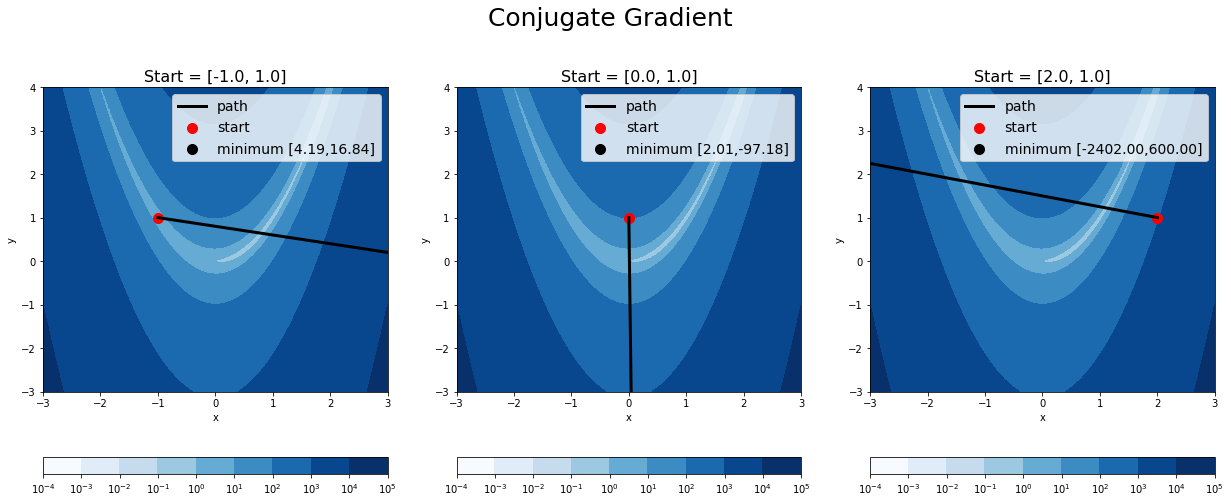

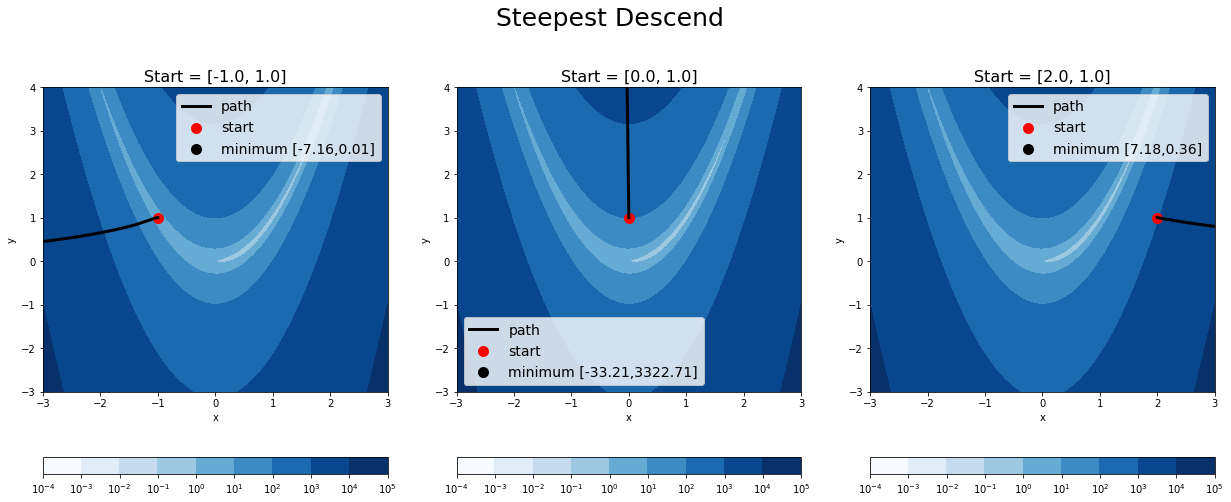

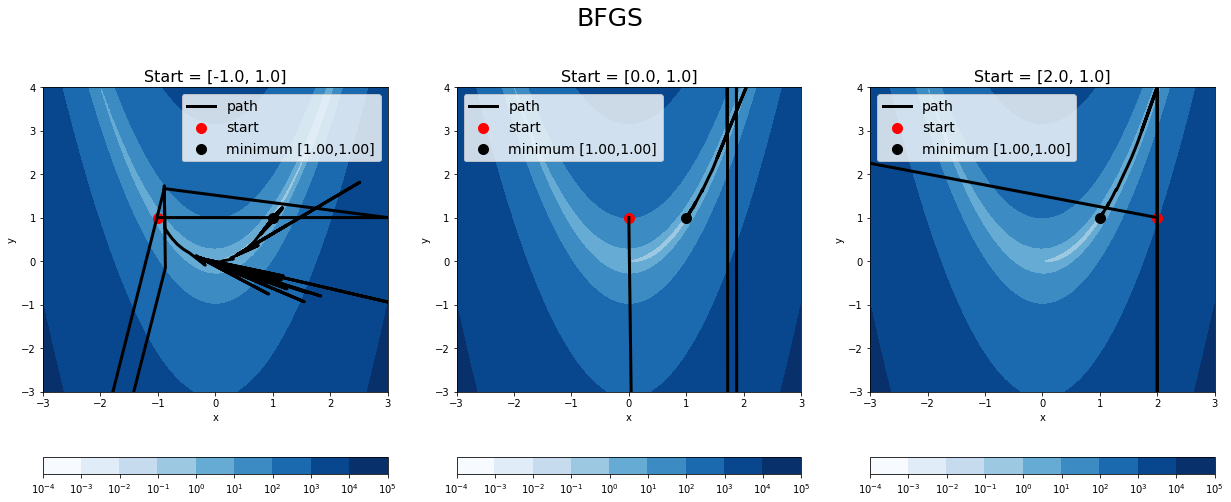

TypeError: list indices must be integers or slices, not tuple

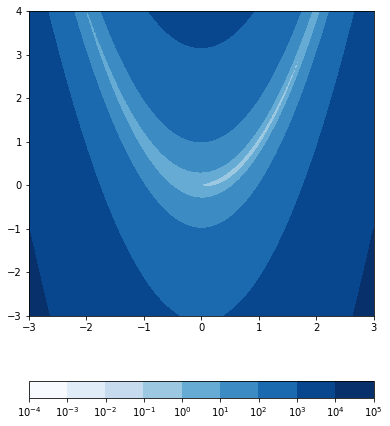

In [22]:
x_grid = np.linspace(-3, 3, 150)
y_grid = np.linspace(-3, 4, 200)
for model in models:
    plot_path(f1, res[model], model, x_grid=x_grid, y_grid=y_grid)

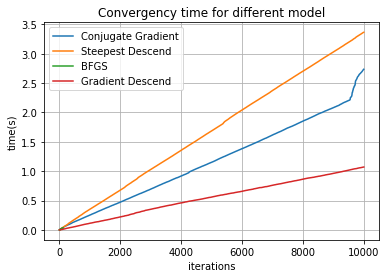

In [23]:
plot_convergency([v[0].time_rec for k,v in res.items()],models)

In [28]:
res.pop('Gradient Descend')

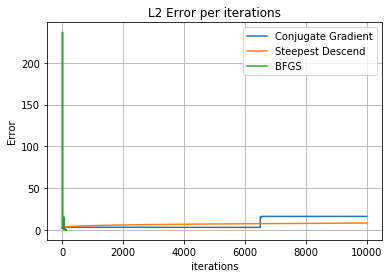

In [29]:
plot_acc([v[0].val_rec for k,v in res.items()],[1,1],models)